In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../") # Add the parent directory to the path
import torch
torch.manual_seed(0) # Set seed before importing other modules
import numpy as np
np.random.seed(0)
import random
random.seed(0)
import os
from utils.get_data import AVMNISTDataModule
from models.dino import MultiModalDINOSemiSupervisedLightning
from utils.get_data import AVMNISTDinoDataModuleExtended
from utils.visualisations import plot
from training_structures.ssl_train import train_and_evaluate_ssl

current_path = os.getcwd()
root_path = "../../"
data_dir=f'{root_path}/data/avmnist/'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


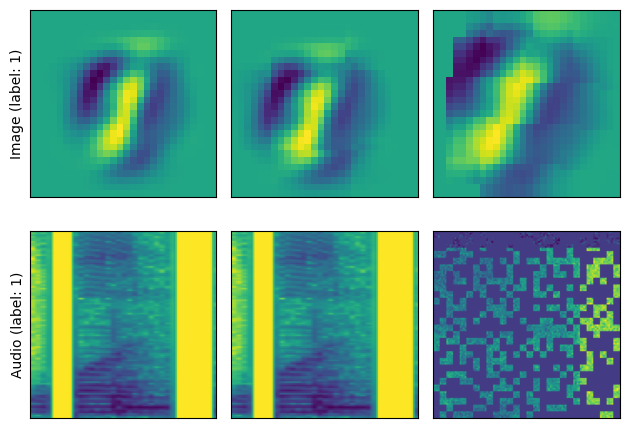

In [2]:
# Image augment demo
data_module = AVMNISTDinoDataModuleExtended(data_dir=data_dir, batch_size=128, num_workers=0)
data_module.setup()
train_dataloader = data_module.train_dataloader()

# run a forward pass to check if the model works
for image, audio, label, (global_images, global_audios, local_images, local_audios) in train_dataloader:

#     print(image.shape)  # (B, 1, 28, 28)
#     print(audio.shape)  # (B, 1, 112, 112)
#     print(label.shape)  # (B,)
#     print(global_images.shape) # [128, 2, 1, 28, 28] # 2 global views
#     print(global_audios.shape) # [128, 2, 1, 112, 112]
#     print(local_images.shape) # [128, 4, 1, 28, 28] # 4 local views
#     print(local_audios.shape) # [128, 4, 1, 112, 112]

    # take an example from each to plot:
    idx = 2
    image = image[idx]
    audio = audio[idx]
    label = label[idx]
    global_image = global_images[idx][0]
    global_audio = global_audios[idx][0]
    local_image = local_images[idx][0]
    local_audio = local_audios[idx][0]

    #reshape for plot:
    image = image.reshape(-1, 28, 28)
    audio = audio.reshape(-1, 112, 112)
    global_image = global_image.reshape(-1, 28, 28)
    global_audio = global_audio.reshape(-1, 112, 112)
    local_image = local_image.reshape(-1, 28, 28)
    local_audio = local_audio.reshape(-1, 112, 112)

    # plot the images:
    plot([[image[0], global_image[0], local_image[0]], [audio[0], global_audio[0], local_audio[0]]], 
         with_orig=False, row_title=[f"Image (label: {label})", f"Audio (label: {label})"],)

    break  # remove this line to run through all batches

In [3]:
# NOTE: the following code should work but takes a very long time to run, 
# thus refer to the run_dino.py script for a version that can run on the computer cluster.

train_data_module = AVMNISTDinoDataModuleExtended(data_dir=data_dir, batch_size=128, num_workers=6)
test_data_module = AVMNISTDataModule(data_dir=data_dir, batch_size=128, num_workers=0)
num_epochs = 100
model_dir, model_name = f"{current_path}", "semi_supervised_dino_multimodal"
module = MultiModalDINOSemiSupervisedLightning(projection_dim=128, output_dim=256, data_dir=data_dir,
                                               learning_rate=0.001, alpha=1, num_epochs=num_epochs, 
                                               use_mixed_precision=True)
seeds = [1, 2, 3]

image, audio, label, (global_images, global_audios, local_images, local_audios) = next(iter(train_dataloader))

C_img, H_img, W_img = global_images.shape[2:]  # (C, H, W) for image
C_aud, H_aud, W_aud = global_audios.shape[2:]  # (C, H, W) for spectrogram
n_global = global_images.shape[1]
n_local = local_images.shape[1]

dummy_image = torch.randn(1, C_img, H_img, W_img)
dummy_audio = torch.randn(1, C_aud, H_aud, W_aud)

dummy_views = (
    torch.randn(1, n_global, C_img, H_img, W_img),  # global_images
    torch.randn(1, n_global, C_aud, H_aud, W_aud),  # global_audios
    torch.randn(1, n_local, C_img, H_img, W_img),   # local_images
    torch.randn(1, n_local, C_aud, H_aud, W_aud),   # local_audios
)

# Final dummy batch
input_data = ([dummy_image, dummy_audio, dummy_views],)

train_and_evaluate_ssl(
    module=module,
    train_data_module=train_data_module,
    test_data_module=test_data_module,
    model_dir=model_dir,
    model_name=model_name,
    input_data=input_data,
    modalities=["audio", "image"],
    seeds=[1, 2, 3],
    num_epochs=num_epochs
)

c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\lightning\fabric\connector.py:572: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\lightning\fabric\loggers\csv_logs.py:268: Experiment logs directory c:\Users\Ward\Desktop\vub-github\Thesis-project\AVMNIST_Experiments\other_ssl\semi-supervised_dino\logs\version_seed1 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model GFLOPs: 1.68 GFLOPs
Model Parameters: 3.61 M parameters
Training with seed 1...



  | Name    | Type                         | Params | Mode 
-----------------------------------------------------------------
0 | model   | MultiModalDINOSemiSupervised | 3.6 M  | train
1 | ce_loss | CrossEntropyLoss             | 0      | train
-----------------------------------------------------------------
2.1 M     Trainable params
1.5 M     Non-trainable params
3.6 M     Total params
14.422    Total estimated model params size (MB)
114       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 430/430 [04:07<00:00,  1.74it/s, v_num=eed1, train_loss_step=3.040, train_loss_epoch=4.620]

c:\Users\Ward\Desktop\vub-github\Thesis-project\AVMNIST_Experiments\other_ssl\semi-supervised_dino\../..\models\dino.py:1063: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True)  # For mixed precision training


Epoch 1:   3%|▎         | 12/430 [00:07<04:18,  1.62it/s, v_num=eed1, train_loss_step=3.300, train_loss_epoch=4.620, mlp_acc=61.30]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined